In [6]:
import os
import pandas as pd
import opendatasets as od
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
plt.figure(figsize=(80,20))

# Download latest version
path = od.download("https://www.kaggle.com/c/rossmann-store-sales")

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


<Figure size 8000x2000 with 0 Axes>

In [7]:
os.listdir('rossmann-store-sales')

['store.csv', 'train.csv', 'sample_submission.csv', 'test.csv']

In [8]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)

In [9]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [10]:
store_df = pd.read_csv('./rossmann-store-sales/store.csv')

In [11]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [12]:
merged_df = ross_df.merge(store_df, how='left', on='Store')

In [13]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [18]:
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [19]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [20]:
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [12]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [14]:
merged_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [15]:
round(merged_df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


In [16]:
#check for duplicate
merged_df.duplicated().sum()

np.int64(0)

In [16]:
merged_df['Date'] = pd.to_datetime(merged_df.Date)

In [21]:
merged_test_df['Date'] = pd.to_datetime(merged_test_df.Date)

<Axes: xlabel='Sales', ylabel='Count'>

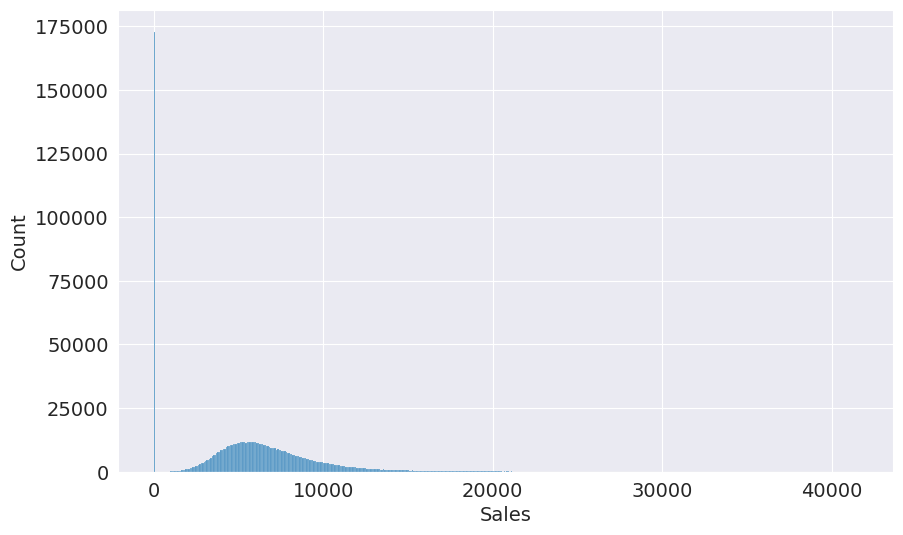

In [19]:
sns.histplot(data=merged_df, x='Sales')

In [20]:
# in this exercise we want to keep the data when they close
merged_df.Open.value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

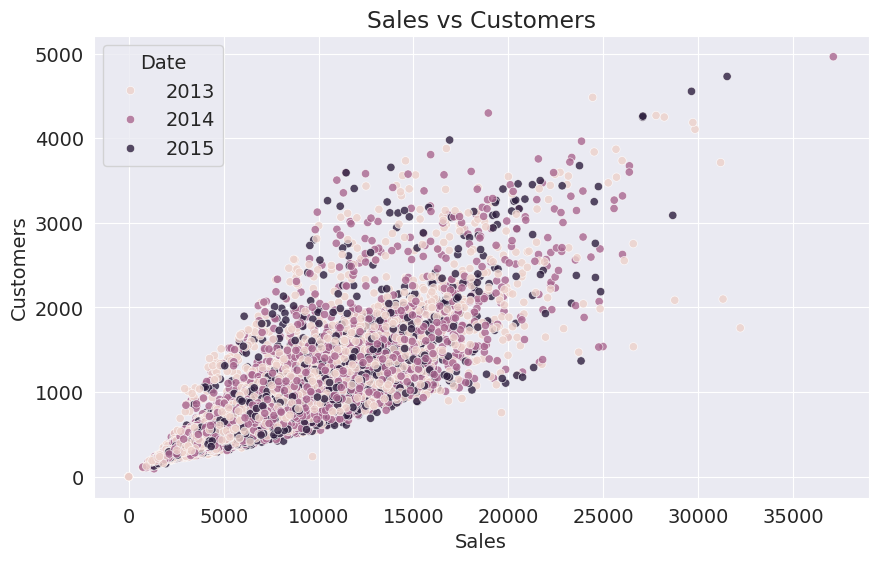

In [21]:
scatter_sample_df = merged_df.sample(40000)
sns.scatterplot(x=scatter_sample_df.Sales, y=scatter_sample_df.Customers, hue=scatter_sample_df.Date.dt.year, alpha=0.8)
plt.title('Sales vs Customers')
plt.show()

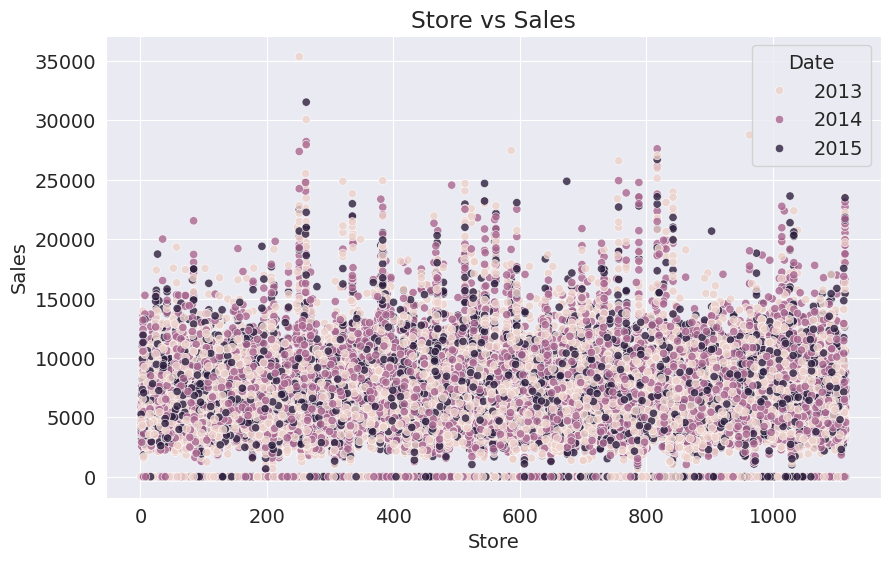

In [22]:
scatter_sample_df = merged_df.sample(40000)
sns.scatterplot(x=scatter_sample_df.Store, y=scatter_sample_df.Sales, hue=scatter_sample_df.Date.dt.year, alpha=0.8)
plt.title('Store vs Sales')
plt.show()

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

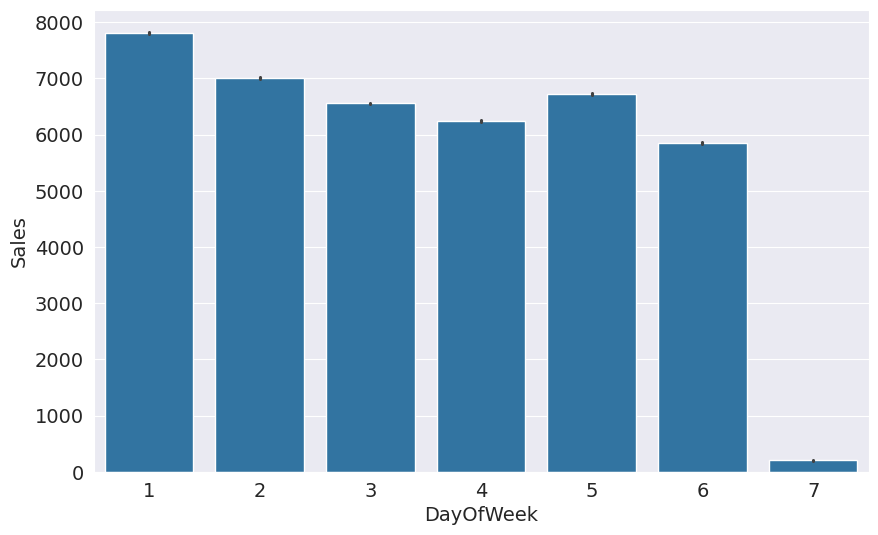

In [23]:
sns.barplot(data=merged_df, x='DayOfWeek', y='Sales')

<Axes: xlabel='Promo', ylabel='Sales'>

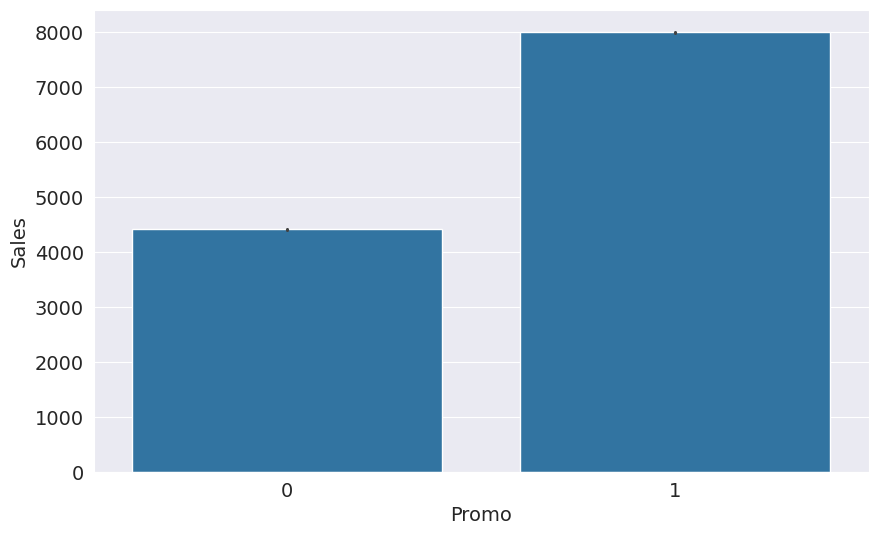

In [24]:
sns.barplot(data=merged_df, x='Promo', y='Sales')

In [25]:
merged_df.select_dtypes(include=np.number).corr()['Sales'].sort_values(ascending=False)

Sales                        1.000000
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
Promo2SinceWeek              0.059558
CompetitionOpenSinceYear     0.012659
Store                        0.005126
CompetitionDistance         -0.019229
Promo2SinceYear             -0.021127
CompetitionOpenSinceMonth   -0.028257
Promo2                      -0.091040
DayOfWeek                   -0.462125
Name: Sales, dtype: float64

In [26]:
# feature engineering
merged_df['Day'] = merged_df.Date.dt.day
merged_df['Month'] = merged_df.Date.dt.month
merged_df['Year'] = merged_df.Date.dt.year

merged_test_df['Day'] = merged_test_df.Date.dt.day
merged_test_df['Month'] = merged_test_df.Date.dt.month
merged_test_df['Year'] = merged_test_df.Date.dt.year

<Axes: xlabel='Year', ylabel='Sales'>

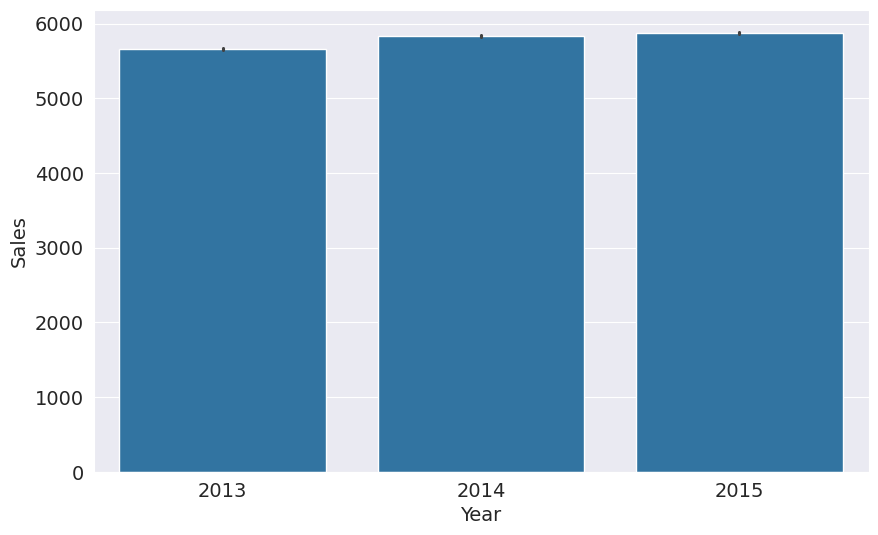

In [27]:
sns.barplot(data=merged_df, x='Year', y='Sales')

<Axes: xlabel='Month', ylabel='Sales'>

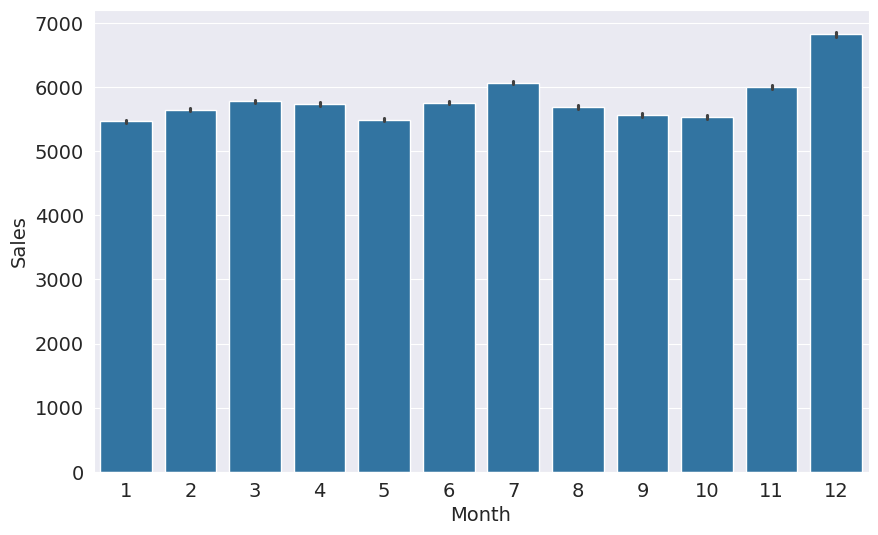

In [28]:
sns.barplot(data=merged_df, x='Month', y='Sales')

<Axes: xlabel='Day', ylabel='Sales'>

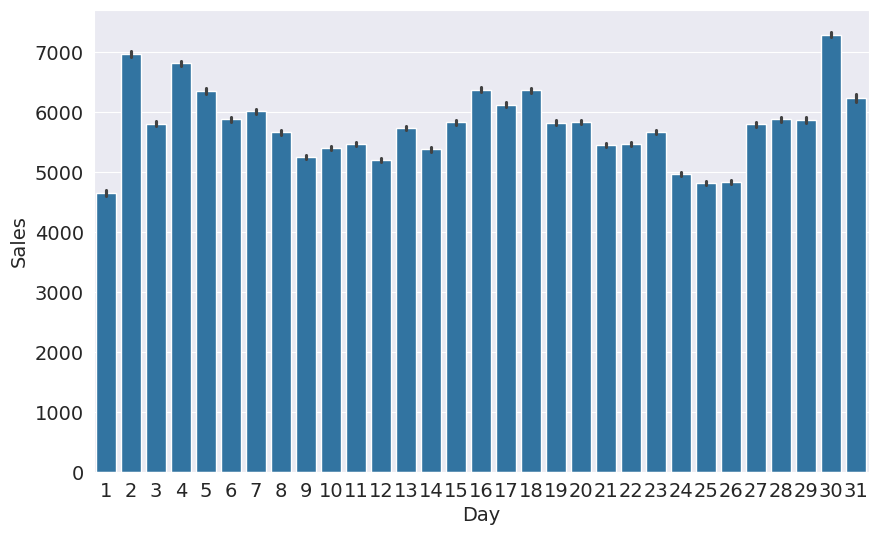

In [29]:
sns.barplot(data=merged_df, x='Day', y='Sales')

In [22]:
input_df = merged_df.drop('Sales', axis=1).drop('Customers', axis=1)
train_targets = merged_df['Sales'].copy()

numeric_cols = input_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = input_df.select_dtypes('object').columns.tolist()

In [31]:
numeric_cols

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Day',
 'Month',
 'Year']

In [32]:
categorical_cols

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
input_df = input_df.apply(LabelEncoder().fit_transform)

In [35]:
input_df

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,0,4,941,1,1,0,1,2,0,115,8,15,0,24,7,3,30,6,2
1,1,4,941,1,1,0,1,0,0,55,10,14,1,5,1,1,30,6,2
2,2,4,941,1,1,0,1,0,0,533,11,13,1,6,2,1,30,6,2
3,3,4,941,1,1,0,1,2,2,60,8,16,0,24,7,3,30,6,2
4,4,4,941,1,1,0,1,0,0,634,3,22,0,24,7,3,30,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1110,1,0,0,0,1,1,0,0,166,5,21,1,13,4,1,0,0,0
1017205,1111,1,0,0,0,1,1,2,2,164,3,13,0,24,7,3,0,0,0
1017206,1112,1,0,0,0,1,1,0,2,467,12,23,0,24,7,3,0,0,0
1017207,1113,1,0,0,0,1,1,0,2,83,12,23,0,24,7,3,0,0,0


In [26]:
# fill missing data with imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'mean')
imputer.fit(input_df)

SimpleImputer()

In [37]:
input_df.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Day                          0
Month                        0
Year                         0
dtype: int64

In [27]:
#scale the values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(input_df)

input_df = scaler.transform(input_df)

In [39]:
input_df

array([[0.00000000e+00, 6.66666667e-01, 1.00000000e+00, ...,
        1.00000000e+00, 5.45454545e-01, 1.00000000e+00],
       [8.97666068e-04, 6.66666667e-01, 1.00000000e+00, ...,
        1.00000000e+00, 5.45454545e-01, 1.00000000e+00],
       [1.79533214e-03, 6.66666667e-01, 1.00000000e+00, ...,
        1.00000000e+00, 5.45454545e-01, 1.00000000e+00],
       ...,
       [9.98204668e-01, 1.66666667e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99102334e-01, 1.66666667e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.66666667e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [40]:
# setup benchmark with simple models
def return_mean(inputs):
    return np.full(len(inputs), merged_df.Sales.mean())

In [41]:
train_preds = return_mean(input_df)

In [42]:
train_preds

array([5773.81897231, 5773.81897231, 5773.81897231, ..., 5773.81897231,
       5773.81897231, 5773.81897231])

In [43]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(train_preds, train_targets)

np.float64(3849.924282837465)

In [44]:
def guess_random(inputs):
    lo, hi = merged_df.Sales.min(), merged_df.Sales.max()
    return np.random.random(len(inputs)) * (hi - lo) + lo

In [45]:
train_preds = guess_random(input_df)

In [46]:
train_preds

array([31355.40595994,   382.52552994,  2762.81194567, ...,
       28356.46434838, 24292.12369303, 29266.54558589])

In [47]:
root_mean_squared_error(train_preds, train_targets)

np.float64(19582.187425311145)

In [48]:
# baseline ML model
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(input_df, train_targets)

LinearRegression()

In [49]:
train_preds = linreg.predict(input_df)

In [50]:
train_preds

array([8355.92307472, 7613.78805663, 6967.089511  , ...,   45.92932085,
        532.47972999, -771.24939266])

In [51]:
root_mean_squared_error(train_preds, train_targets)

np.float64(2561.913220732255)

In [2]:
def try_model(model):
    model.fit(input_df, train_targets)

    train_preds = model.predict(input_df)

    print('rmse: {}'.format(root_mean_squared_error(train_preds, train_targets)))

In [53]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

In [54]:
for mdl in [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor()]:
    try_model(mdl)

rmse: 2561.913220732255
rmse: 2562.016350229006
rmse: 2562.1964961405147
rmse: 3214.283615584582
rmse: 2562.553615438148


In [55]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [56]:
try_model(DecisionTreeRegressor(random_state=42))

rmse: 0.0


In [4]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
try_model(RandomForestRegressor(random_state=42, n_jobs=-1))